In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
import time

from math import *

In [31]:
W=2*np.pi
T=(2*np.pi)/W
n=50
L=n*T

N_grid=20000
t=np.linspace(0,L,N_grid)
h=t[1]-t[0]
p=int(round(T/h))

d=2.5
dd=-2.45

dw_samples=np.linspace(0.05, 1.25, 200)
dual_border=[]

In [32]:
for dw in dw_samples:
    if (dw==0.05):
        left=1
        right=N_grid-2*p-1
    else:
        right=min(N_grid-2*p-1, left+20)
        left=max(1, left-20)

    start = time.time()
    while (right-left>1):
        s=round((left+right)/2)

        k0=np.array([d]*N_grid)
        k0[2*p:2*p+s]=d+dd
        k0_f=interpolate.interp1d(t, k0, bounds_error=False, fill_value="extrapolate")

        f=lambda t, x: 2*dw-k0_f(t)*sin(x)

        init=np.arcsin(2*dw/k0[0])

        theta=[0]*N_grid
        for i in range(N_grid):
            if i==0:
                theta[i]=init
            else:
                k1=f(t[i-1], theta[i-1])*h
                k2=f(t[i-1]+h/2, theta[i-1]+k1/2)*h
                k3=f(t[i-1]+h/2, theta[i-1]+k2/2)*h
                k4=f(t[i-1]+h, theta[i-1]+k3)*h

                theta[i]=theta[i-1]+(k1+2*k2+2*k3+k4)/6

        theta=np.array(theta)
        x0=np.sin(W*t)
        y0=np.sin(W*t+theta)

        C_0=[0]*N_grid
        for i in range(N_grid):
            if (t[i]-T/2>=0) and (t[i]+T/2<=L):
                C_0[i]=np.corrcoef(x0[i-int(p/2):i+int(p/2)], y0[i-int(p/2):i+int(p/2)])[0][1]
            else:
                C_0[i]=nan

        phi0=np.arccos(C_0)
        k_hat=np.divide(np.array([2*dw]*N_grid), np.sin(phi0))

        dmin=argrelextrema(k_hat, np.less)
        n_min=dmin[0].shape[0]
        extr=[]

        eps=0.001

        for i in range(n_min):
            if ((((i==0) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i+1]]))
                or ((i==n_min-1) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i-1]]))
                or ((k_hat[dmin[0][i]]<k_hat[dmin[0][i-1]]) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i+1]])))
                and (dmin[0][i]>2*p) and (abs(k_hat[dmin[0][i]]-d)>eps)):
                    extr.append(dmin[0][i])

        dk=np.diff(k_hat)/h
        dk=np.nan_to_num(dk)
        #print(left, right)
        if (max(dk)>25) or ((len(extr)>1) and (extr[0]<=2*p+s) and (extr[1]>2*p+s)):
            right=s
        else:
            left=s

    stop = time.time()        
    print('-----: ', stop-start, left)
    dual_border.append(left)
    
np.savetxt('PT2407_50_20000_extr2.out', dual_border, delimiter=',')

/usr/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


-----:  156.36111688613892 12192
-----:  48.718154430389404 12172
-----:  48.778244495391846 12152
-----:  48.65411353111267 12132
-----:  48.96761393547058 12112
-----:  48.80192422866821 12092
-----:  48.76582932472229 12072
-----:  48.89142179489136 12052
-----:  48.7708899974823 12032
-----:  48.87668418884277 12051
-----:  48.82973551750183 12031
-----:  48.90217661857605 12011
-----:  49.02868103981018 11991
-----:  48.800726890563965 12010
-----:  48.801719188690186 12029
-----:  48.417144536972046 12009
-----:  48.39665699005127 11989
-----:  48.65240168571472 12008
-----:  48.457846879959106 11988
-----:  48.00173830986023 11968
-----:  48.24966597557068 11948
-----:  48.288808822631836 11928
-----:  48.302045822143555 11947
-----:  48.378252029418945 11927
-----:  48.309221506118774 11907
-----:  48.19523477554321 11887
-----:  48.20530915260315 11867
-----:  48.012726068496704 11847
-----:  48.12319278717041 11827
-----:  48.08793497085571 11807
-----:  48.36162734031677 117

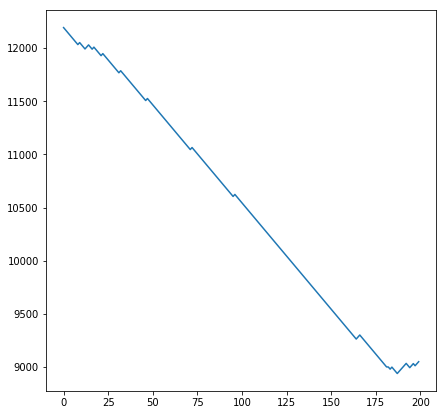

In [34]:
plt.figure(figsize=(7,7))
plt.plot(dual_border)
plt.show()

In [38]:
dw_samples[96]

0.62889447236180906

In [41]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
     
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2

    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)

    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

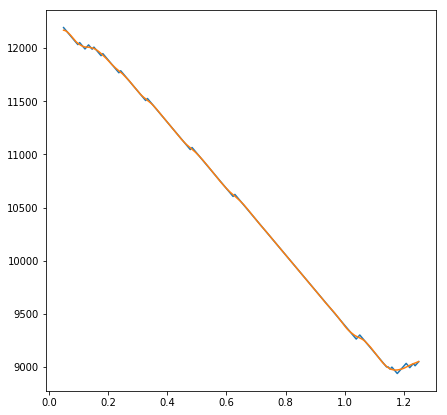

In [53]:
dual_sm=savitzky_golay(np.asarray(dual_border), 51, 10)

plt.figure(figsize=(7,7))
plt.plot(dw_samples, dual_border)
plt.plot(dw_samples, dual_sm)
plt.show()